# Clustering Collections

In [256]:
import math

import numpy as np
import numpy.typing as npt
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

import jsonlines
from pprint import pprint

In [148]:
sns.set_theme(style='darkgrid')

## APIs

In [21]:
from wikidata.client import Client

In [23]:
wikidata = Client()

## Data

In [13]:
from itertools import islice
from collections import Counter

In [7]:
limit = 10_000

In [8]:
def read(path, limit):
    with jsonlines.open(path, 'r') as reader:
        for doc in islice(reader.iter(skip_empty=True, skip_invalid=True), limit):
            # rank_feature must be positive

            if doc['data']['collection_name'].startswith('Lists of'):
                continue
            doc['template']['collection_rank'] = max(1, doc['template']['collection_rank'])  # remove?
            doc['metadata']['members_count'] = len(doc['data']['names'])
            if doc['metadata']['members_count'] > 10000:
                continue

            yield doc

In [14]:
wikidata_types_counter = Counter()

In [70]:
for doc in read('../elasticsearch/list_links_collections_sorted.jsonl', limit):
    wikidata_types_counter.update([doc['template']['collection_type_wikidata_id']])

In [37]:
wikidata_type_mapping = {
    type_: wikidata.get(type_, load=True).label
    for type_, freq in wikidata_types_counter.most_common()
    if freq >= 10
}

In [41]:
for type_, freq in wikidata_types_counter.most_common():
    if freq < 10:
        break
    
    print(f'{freq: >5}  {type_: >10} {wikidata_type_mapping[type_]}')

 1940          Q5 human
 1032      Q11424 film
  860      Q95074 fictional character
  440   Q21191270 television series episode
  324        Q515 city
  264       Q6256 country
  223       Q7889 video game
  140    Q1248784 airport
  123       Q7366 song
  110      Q15416 television program
   97      Q41176 building
   97     Q618779 award
   87       Q3918 university
   72       Q7278 political party
   63        Q198 war
   61   Q18643213 military equipment
   56       Q4022 river
   54      Q23442 island
   54    Q1197685 public holiday
   50      Q14660 flag
   47       Q8502 mountain
   47        Q571 book
   44     Q783794 company
   44      Q22687 bank
   42      Q11446 ship
   40  Q105543609 musical work/composition
   34      Q46970 airline
   32     Q483110 stadium
   31     Q482994 album
   31    Q2074737 municipality of Spain
   29       Q7944 earthquake
   29      Q11032 newspaper
   27     Q134556 single
   26      Q23397 lake
   25     Q215380 musical group
   24    Q3

* `Q11424` - film
* `Q95074` - fictional character
* `Q6256` - country
* `Q7889` - video game
* `Q8171` - word
* `Q1485500` - tangible good

In [151]:
types = ['film', 'fictional character', 'country', 'video game', 'word', 'tangible good']

In [42]:
collections_by_type = {
    'film': [],
    'fictional character': [],
    'country': [],
    'video game': [],
    'word': [],
    'tangible good': []
}

In [51]:
for doc in read('../elasticsearch/list_links_collections_sorted.jsonl', limit):
    type_ = doc['template']['collection_type_wikidata_id']
    if type_ not in wikidata_type_mapping:
        continue
    
    type_name = wikidata_type_mapping[type_].get('en')
    
    if type_name in collections_by_type:
        collections_by_type[type_name].append(doc)

In [154]:
for type_,  in types:
    print(f'----- {type_} -----')
    for name in [coll['data']['collection_name'] for coll in collections_by_type[type_]][:15]:
        print(name)
    print()

----- film -----
Highest-grossing films
Marvel Cinematic Universe films
Highest-grossing Indian films
Highest-grossing films
Marvel Cinematic Universe films
Highest-grossing Indian films
James Bond films
Hindi films of 2022
American films of 2022
Walt Disney Pictures films
Johnny Depp filmography
Highest-grossing films in India
Tom Cruise filmography
Disney theatrical animated feature films
Walt Disney Animation Studios films

----- fictional character -----
A Certain Magical Index characters
One Piece characters
Harry Potter characters
Stranger Things characters
Star Wars characters
Naruto characters
The Boys characters
Bleach characters
Dragon Ball characters
Attack on Titan characters
The Walking Dead (TV series) characters
Hunter %C3%97 Hunter characters
Characters of the Marvel Cinematic Universe
Sonic the Hedgehog characters
Demon Slayer: Kimetsu no Yaiba characters

----- country -----
Countries and dependencies by area
Countries by GDP (nominal)
Countries by GDP (nominal) per c

## Metrics

In [87]:
import numba

In [94]:
def normalized_names(doc) -> list[str]:
    return [name['normalized_name'] for name in doc['data']['names']]

In [261]:
def tokens(doc) -> list[str]:
    return []  # TODO

In [102]:
# @numba.njit
def dice_dissimilarity(names1: set[str], names2: set[str]) -> float:
#     names1 = set(normalized_names(doc1))
#     names2 = set(normalized_names(doc2))
    
    same_names_count = len(names1 & names2)
    return 1 - 2 * same_names_count / (len(names1) + len(names2))

In [257]:
def cosine_dissimilarity(names1: set[str], names2: set[str]) -> float:
    same_names_count = len(names1 & names2)
    return 1 - same_names_count / (math.sqrt(len(names1) * len(names2)))

### Data preparation

In [86]:
all_collections = [
    collection
    for type_collections in collections_by_type.values()
    for collection in type_collections
]
len(all_collections)

2417

In [258]:
y_type = np.concatenate([[i] * len(collections) for i, collections in enumerate(collections_by_type.values())])
y_name = [coll['data']['collection_name'] for coll in all_collections]

In [259]:
doc_names = [
    set(normalized_names(collection))
    for collection in all_collections
]

In [262]:
doc_tokens = [
    set(tokens(collection))  # FIXME not set? Counter?
    for collection in all_collections
]

### Computing distances

In [263]:
from typing import Callable

In [135]:
# @numba.njit
def calculate_pairwise_distances(doc_names: list[set[str]], metric: Callable) -> npt.NDArray[float]:
    n = len(doc_names)
    dists = np.zeros((n, n), dtype=np.float64)
    for i, doc1_names in enumerate(doc_names):
        for j, doc2_names in enumerate(doc_names):
            dists[i, j] = metric(doc1_names, doc2_names)
    return dists

In [138]:
%%time
dice_dists = calculate_pairwise_distances(doc_names, dice_dissimilarity)
dice_dists.shape

CPU times: user 9.84 s, sys: 19 ms, total: 9.86 s
Wall time: 9.86 s


(2417, 2417)

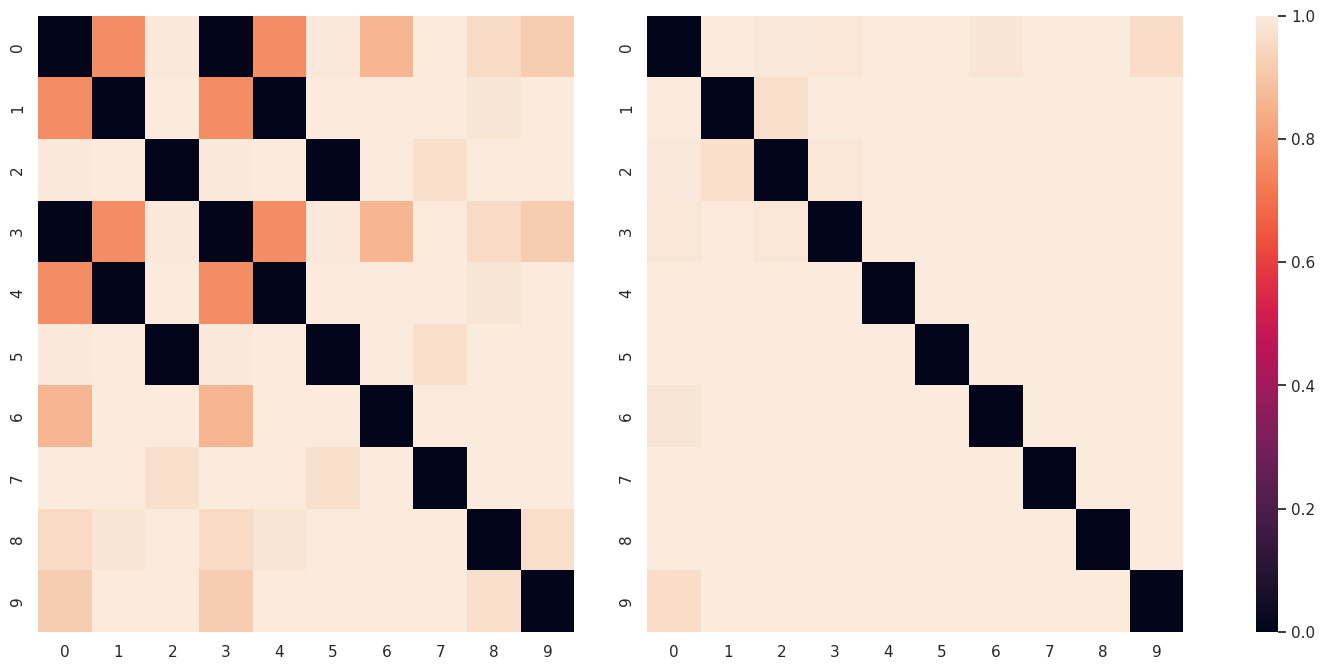

In [248]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, width_ratios=[.49, .49, .02], figsize=(16, 8))
sns.heatmap(dice_dists[:10, :10], ax=ax1, cbar_ax=ax3)
sns.heatmap(dice_dists[::250, ::250], ax=ax2, cbar_ax=ax3)
plt.show()

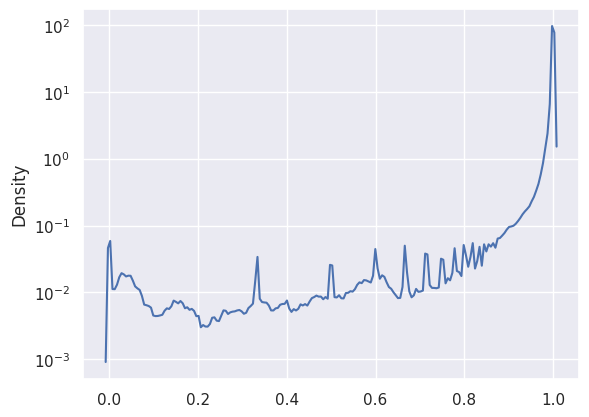

In [277]:
sns.kdeplot(x=dice_dists.reshape(-1))
plt.yscale('log')
plt.show()

In [264]:
%%time
cosine_dists = calculate_pairwise_distances(doc_names, cosine_dissimilarity)
cosine_dists.shape

CPU times: user 10.7 s, sys: 47.8 ms, total: 10.8 s
Wall time: 10.8 s


(2417, 2417)

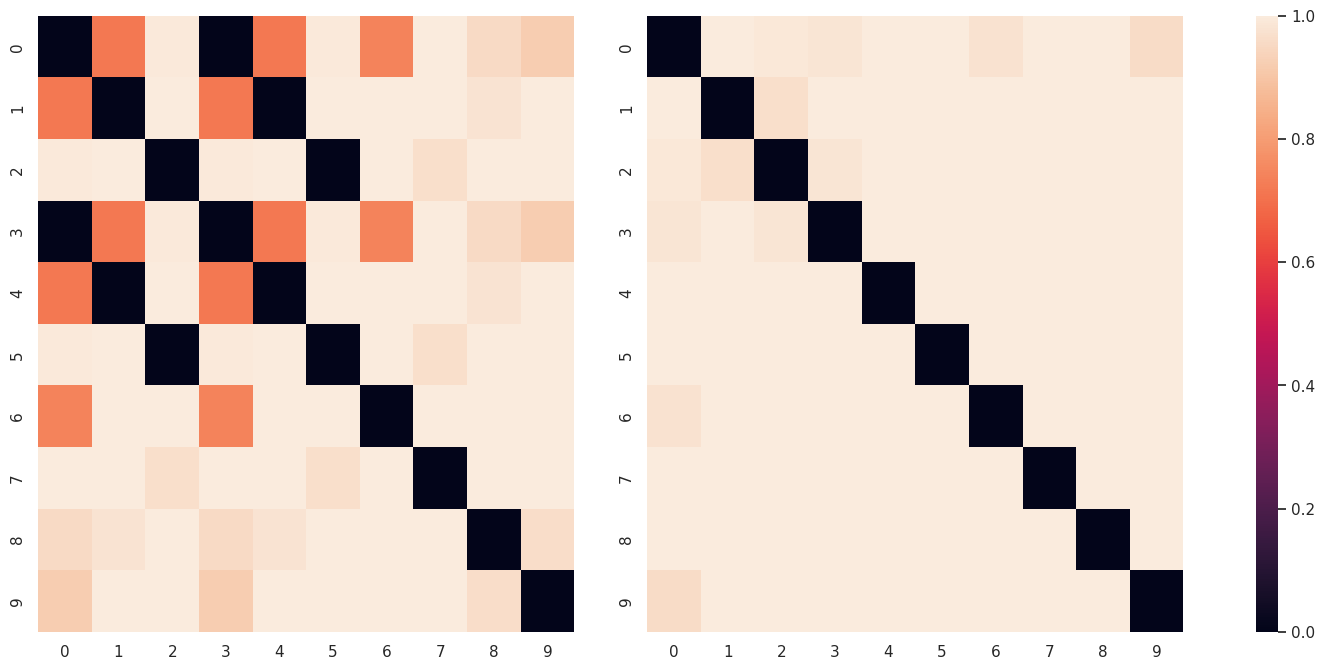

In [265]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, width_ratios=[.49, .49, .02], figsize=(16, 8))
sns.heatmap(cosine_dists[:10, :10], ax=ax1, cbar_ax=ax3)
sns.heatmap(cosine_dists[::250, ::250], ax=ax2, cbar_ax=ax3)
plt.show()

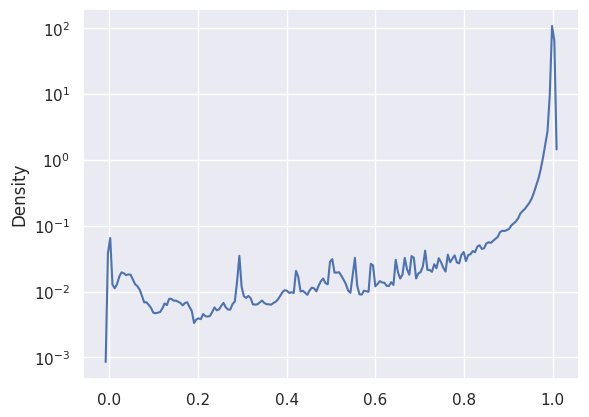

In [278]:
sns.kdeplot(x=cosine_dists.reshape(-1))
plt.yscale('log')
plt.show()

## Visualizing

In [155]:
from sklearn.manifold import TSNE

### Dice dissimilarity

In [280]:
%%time
tsne = TSNE(n_components=2, perplexity=5, n_iter=1000, metric='precomputed', n_jobs=-1)
X_tsne_dice = tsne.fit_transform(dice_dists)

X_tsne_dice.shape

/home/goader/.local/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/home/goader/.local/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



CPU times: user 1min 16s, sys: 97.3 ms, total: 1min 16s
Wall time: 7.04 s


(2417, 2)

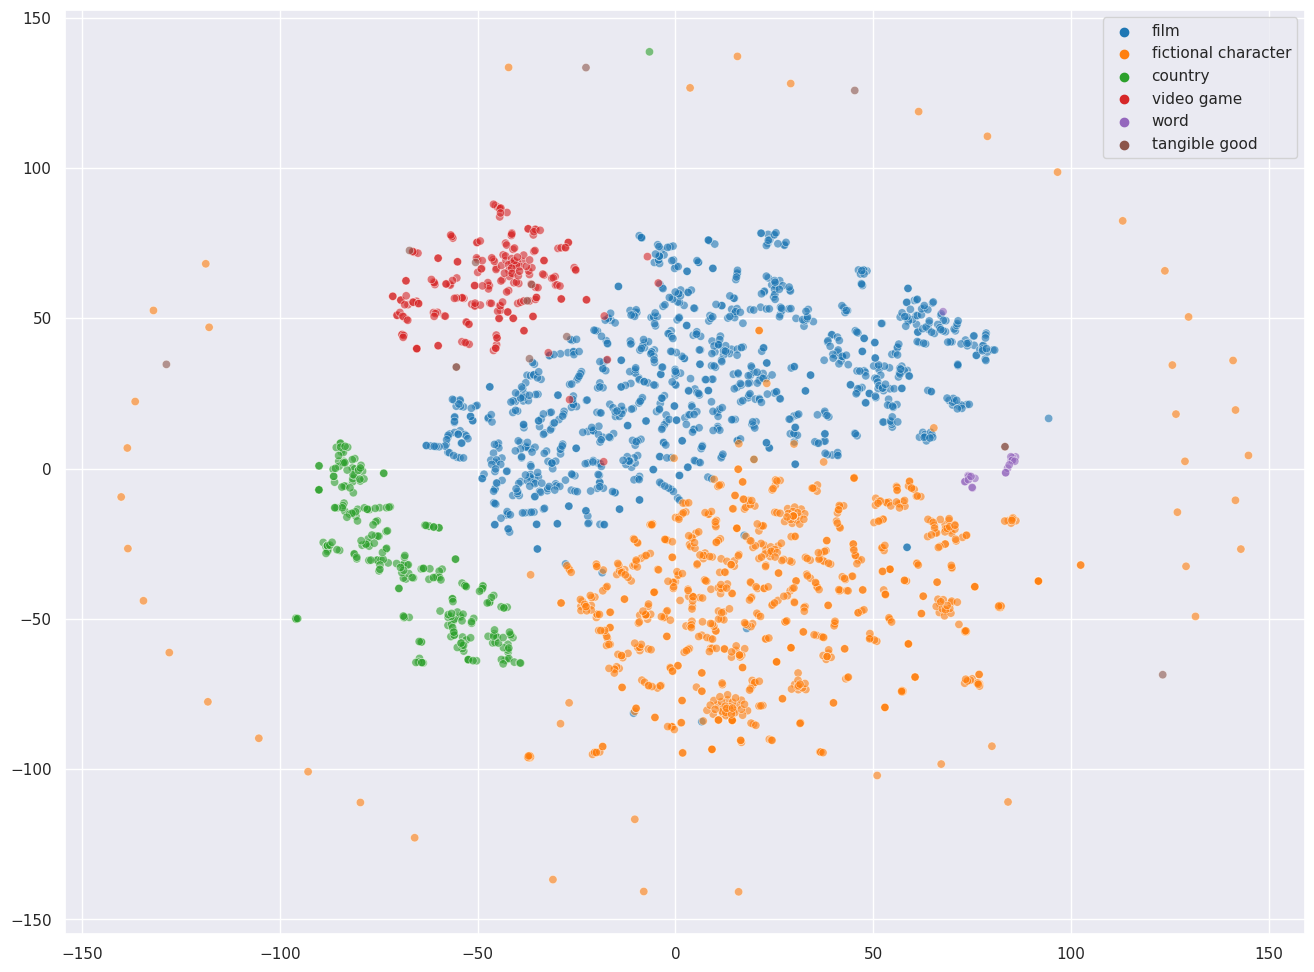

In [281]:
plt.figure(figsize=(16, 12))

sns.scatterplot(
    x=X_tsne_dice[:, 0],
    y=X_tsne_dice[:, 1],
    hue=[types[i] for i in y_type],
    palette='tab10',
    alpha=0.6
)

plt.gcf().set_dpi(100)
plt.show()

In [282]:
fig = px.scatter(
    x=X_tsne_dice[:, 0],
    y=X_tsne_dice[:, 1],
    hover_name=y_name,
    hover_data={
        'first 4 names': [','.join(sorted(doc)[:4]) for doc in doc_names]
    },
    size_max=1e-6,
    color=[types[i] for i in y_type],
    opacity=0.65,
#     width=1200,  # figure width in pixels
#     height=800,  # figure height in pixels
)
fig.update_traces(marker={'size': 3})
fig.update_layout(title_text='Collection Clusters [dice dissimilarity]', title_x=0.5)
fig.show()

### Cosine dissimilarity

In [268]:
%%time
tsne = TSNE(n_components=2, perplexity=5, n_iter=1000, metric='precomputed', n_jobs=-1)
X_tsne_cosine = tsne.fit_transform(cosine_dists)

X_tsne_cosine.shape

/home/goader/.local/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/home/goader/.local/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



CPU times: user 1min 7s, sys: 161 ms, total: 1min 7s
Wall time: 6.34 s


(2417, 2)

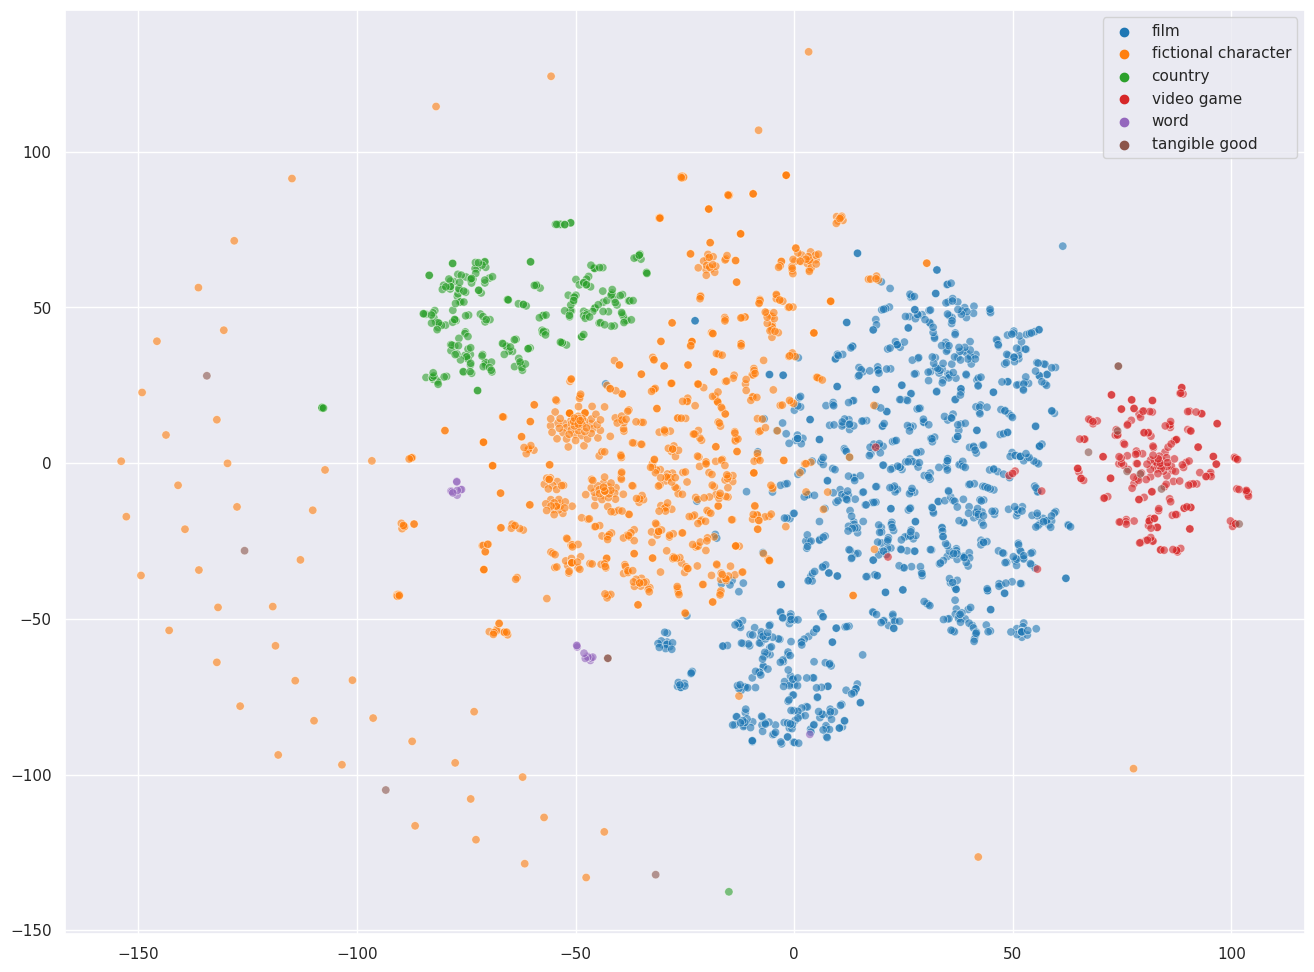

In [269]:
plt.figure(figsize=(16, 12))

sns.scatterplot(
    x=X_tsne_cosine[:, 0],
    y=X_tsne_cosine[:, 1],
    hue=[types[i] for i in y_type],
    palette='tab10',
    alpha=0.6
)

plt.gcf().set_dpi(100)
plt.show()

In [270]:
fig = px.scatter(
    x=X_tsne_cosine[:, 0],
    y=X_tsne_cosine[:, 1],
    hover_name=y_name,
    hover_data={
        'first 4 names': [','.join(sorted(doc)[:4]) for doc in doc_names]
    },
    size_max=1e-6,
    color=[types[i] for i in y_type],
    opacity=0.65,
#     width=1200,  # figure width in pixels
#     height=800,  # figure height in pixels
)
fig.update_traces(marker={'size': 3})
fig.update_layout(title_text='Collection Clusters [cosine dissimilarity]', title_x=0.5)
fig.show()

## Clustering

In [357]:
from typing import Any

from sklearn.cluster import AffinityPropagation, DBSCAN

### AffinityPropagation

In [402]:
def generate_html_report_affinity(clusters: dict[str, Any], dists: npt.NDArray[float]) -> str:
    html = []

    for cluster_no, cluster in enumerate(clusters):
        center = cluster['center']
        members = cluster['members']

        html.append(f'<h1>cluster {cluster_no}</h2>')
        html.append(f'center point name - "{y_name[center]}"</br>')
        html.append(f'center point type - "{y_type[center]}"</br>')

        html.append('<table>')
        html.append('<thead>')
        html.append('''<tr>
                        <th style="width: 10%">name</th>
                        <th style="width: 8%">type</th>
                        <th style="width: 3%">distance to center</th>
                        <th style="width: 79%">names</th>
                    </tr>''')
        html.append('</thead>')

        html.append('<tbody>')

        for member in members:
            names = normalized_names(all_collections[member])[:100]
            names_str = ', '.join(names)

            html.append(f'<tr><td>{y_name[member]}</td><td>{types[y_type[member]]}</td><td>{dists[member, center]}</td><td>{names_str}</td></tr>')

        html.append('</tbody>')
        html.append('</table>')
        
    return '\n'.join(html)

#### Dice dissimilarity

In [331]:
ap = AffinityPropagation(affinity='precomputed', random_state=42, max_iter=2000)

In [332]:
%%time
labels = ap.fit_predict(dice_dists)

CPU times: user 1min 58s, sys: 107 ms, total: 1min 58s
Wall time: 1min 58s


/home/goader/.local/lib/python3.10/site-packages/sklearn/cluster/_affinity_propagation.py:236: ConvergenceWarning:

Affinity propagation did not converge, this model may return degenerate cluster centers and labels.



In [339]:
clusters_count = ap.cluster_centers_indices_.shape[0]
clusters = []
for cluster_no in range(clusters_count):
    cluster = {
        'center': ap.cluster_centers_indices_[cluster_no],
        'members': np.where(labels == cluster_no)[0]
    }
    clusters.append(cluster)

In [360]:
with open('affinity-dice-full-names-report.html', 'w', encoding='utf-8') as f:
    f.write(generate_html_report_affinity(clusters), dice_dists)

#### Cosine dissimilarity

In [361]:
ap = AffinityPropagation(affinity='precomputed', random_state=42, max_iter=2000)

In [362]:
%%time
labels = ap.fit_predict(cosine_dists)

CPU times: user 2min 2s, sys: 130 ms, total: 2min 2s
Wall time: 2min 2s


/home/goader/.local/lib/python3.10/site-packages/sklearn/cluster/_affinity_propagation.py:236: ConvergenceWarning:

Affinity propagation did not converge, this model may return degenerate cluster centers and labels.



In [363]:
clusters_count = ap.cluster_centers_indices_.shape[0]
clusters = []
for cluster_no in range(clusters_count):
    cluster = {
        'center': ap.cluster_centers_indices_[cluster_no],
        'members': np.where(labels == cluster_no)[0]
    }
    clusters.append(cluster)

In [364]:
with open('affinity-cosine-full-names-report.html', 'w', encoding='utf-8') as f:
    f.write(generate_html_report_affinity(clusters), cosine_dists)

### DBSCAN

In [449]:
def generate_html_report_dbscan(clusters: dict[str, Any], outliers: npt.NDArray[int], dists: npt.NDArray[float]) -> str:
    html = []

    for cluster_no, cluster in enumerate(clusters):
        core_points = cluster['core_points']
        members = cluster['members']

        html.append(f'<h1>cluster {cluster_no}</h1>')
        
        html.append(f'<h3>core points</h3>')
        for core_point in core_points:
            html.append(f'core point name - "{y_name[core_point]}" | type - "{y_type[center]}"</br>')

        html.append('<table>')
        html.append('<thead>')
        html.append('''<tr>
                        <th style="width: 10%">name</th>
                        <th style="width: 8%">type</th>
                        <th style="width: 10%">closest core point name</th>
                        <th style="width: 3%">distance to closest core point</th>
                        <th style="width: 69%">names</th>
                    </tr>''')
        html.append('</thead>')

        html.append('<tbody>')

        for member in members:
            names = normalized_names(all_collections[member])[:100]
            names_str = ', '.join(names)
            
            closest_core_point_name = y_name[core_points[dists[member, core_points].argmin()]]
            distance_to_closest_core_point = dists[member, core_points].min()

            html.append(f'<tr><td>{y_name[member]}</td><td>{types[y_type[member]]}</td><td>{closest_core_point_name}</td><td>{distance_to_closest_core_point}</td><td>{names_str}</td></tr>')

        html.append('</tbody>')
        html.append('</table>')
        
    html.append('<h1>outliers</h1>')
    
    html.append('<table>')
    html.append('<thead>')
    html.append('''<tr>
                    <th style="width: 10%">name</th>
                    <th style="width: 8%">type</th>
                    <th style="width: 10%">closest point name</th>
                    <th style="width: 3%">distance to closest point</th>
                    <th style="width: 69%">names</th>
                </tr>''')
    html.append('</thead>')

    html.append('<tbody>')

    for outlier in outliers:
        names = normalized_names(all_collections[outlier])[:100]
        names_str = ', '.join(names)

        dists_to_all_points = dists[outlier, :]
        dists_to_all_points[outlier] = np.inf
        
        closest_point_name = y_name[dists_to_all_points.argmin()]
        distance_to_closest_point = dists_to_all_points.min()

        html.append(f'<tr><td>{y_name[outlier]}</td><td>{types[y_type[outlier]]}</td><td>{closest_point_name}</td><td>{distance_to_closest_point}</td><td>{names_str}</td></tr>')

    html.append('</tbody>')
    html.append('</table>')    
        
    return '\n'.join(html)

#### Dice dissimilarity

In [450]:
dbscan = DBSCAN(eps=0.8, min_samples=5, metric='precomputed', n_jobs=-1)

In [451]:
%%time
labels = dbscan.fit_predict(dice_dists)

CPU times: user 44.2 ms, sys: 2 µs, total: 44.2 ms
Wall time: 42.6 ms


In [452]:
clusters_count = labels.max() + 1
clusters = []
for cluster_no in range(clusters_count):
    core_points = dbscan.core_sample_indices_[labels[dbscan.core_sample_indices_] == cluster_no]
    cluster = {
        'core_points': core_points,
        'members': np.where(labels == cluster_no)[0]
    }
    clusters.append(cluster)
    
outliers = np.where(labels == -1)[0]

In [453]:
with open('dbscan-dice-full-names-report.html', 'w', encoding='utf-8') as f:
    f.write(generate_html_report_dbscan(clusters, outliers, dice_dists))

#### Cosine dissimilarity

In [454]:
dbscan = DBSCAN(eps=0.8, min_samples=5, metric='precomputed', n_jobs=-1)

In [455]:
%%time
labels = dbscan.fit_predict(cosine_dists)

CPU times: user 47 ms, sys: 36 µs, total: 47 ms
Wall time: 45.6 ms


In [456]:
clusters_count = labels.max() + 1
clusters = []
for cluster_no in range(clusters_count):
    core_points = dbscan.core_sample_indices_[labels[dbscan.core_sample_indices_] == cluster_no]
    cluster = {
        'core_points': core_points,
        'members': np.where(labels == cluster_no)[0]
    }
    clusters.append(cluster)
    
outliers = np.where(labels == -1)[0]

In [457]:
with open('dbscan-cosine-full-names-report.html', 'w', encoding='utf-8') as f:
    f.write(generate_html_report_dbscan(clusters, outliers, cosine_dists))